----------------------------------------------------------------------------------------------------------------------

# Manually Created Algorithm - Interaction Chart Example

----------------------------------------------------------------------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import make_scorer, r2_score
from sklearn.svm import LinearSVR, SVR
from xgboost import XGBRegressor
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
def score_to_stats(scores):
    
    return {score:round(values.mean(),4) for score, values in scores.items()}

In [3]:
def rmsle_custom(y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))
rmsle_score = make_scorer(score_func=rmsle_custom)

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Data Importing

In [7]:
df_train = pd.read_csv('train_master.csv')
df_test = pd.read_csv('test_master.csv')

## Output varible logarithmic transformation

In [8]:
df_train['SalePrice_log'] = np.log1p(df_train['SalePrice'])

In [9]:
df_train = df_train.drop(['Id','SalePrice'], axis = 1)

In [10]:
df_test = df_test.drop('Id', axis = 1)

## Pre-processing and data cleaning

In [11]:
outlier1 = df_train[df_train['GrLivArea'] > 4500].index
outlier2 = df_train[df_train["1stFlrSF"] > 4000].index
outlier3 = df_train[df_train["TotalBsmtSF"] > 4000].index

In [12]:
# 523, 1298
df_train = df_train.drop(outlier1)

In [13]:
missing_values_attribute = ['PoolQC','MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
correlated_attributes = ['GarageArea', '1stFlrSF']

In [14]:
df_train = df_train.drop(missing_values_attribute, axis = 1)
df_test = df_test.drop(missing_values_attribute, axis = 1)

In [15]:
df_train = df_train.drop(correlated_attributes, axis = 1)
df_test = df_test.drop(correlated_attributes, axis = 1)

## Attributes mapping and dummy coding

In [16]:
df_train['train'] = 1
df_test['train'] = 0

In [17]:
df_combined = pd.concat([df_train, df_test])

In [18]:
df_combined = df_combined.reset_index(drop = True)

In [19]:
cat_mapping = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
scale_attributes = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']
for i in df_combined[scale_attributes]:
    df_combined[i] = df_combined[i].map(cat_mapping)

In [20]:
df_cat = df_combined.select_dtypes(include = ['object'])

In [21]:
df_cat_columns = df_cat.columns

In [22]:
df_cat_dummies = pd.get_dummies(df_cat)

In [23]:
df_combined = df_combined.drop(df_cat_columns, axis = 1)

In [24]:
df_combined = pd.concat([df_combined, df_cat_dummies], axis = 1)

In [25]:
df_train = df_combined[df_combined['train'] == 1]
df_train = df_train.drop(['train'], axis = 1)

In [26]:
df_train = df_train.fillna(df_train.mean())

In [27]:
X = df_train.drop('SalePrice_log', axis = 1)
y = df_train['SalePrice_log']

In [28]:
scoring = {'rmsle': rmsle_score,
           'r2': 'r2'}

## Interaction Examining - Example

In [29]:
from sklearn import tree
from matplotlib.pyplot import figure

In [37]:
def get_interactions(tree_model, feature_names, plot_tree = True):
    if plot_tree:
        figure(figsize=(15,15))
        tree.plot_tree(tree_model, feature_names = feature_names, class_names = tree_model.classes_, filled = True,
                       rounded = True, fontsize = 10)
    children_left = tree_model.tree_.children_left
    children_right = tree_model.tree_.children_right
    feature = tree_model.tree_.feature
    #treshold = tree_model.tree_.treshold
    
    def get_paths(node):
        if feature[node] < 0: return []
        feat = feature_names[feature[node]]
        left = get_paths(children_left[node])
        right = get_paths(children_right[node])
        left = [feat + '___' + l for l in left] if left else [feat]
        right = [feat + '___' + r for r in right] if right else [feat]
        #return left+right if left+right else [feat]
        return left + right
    
    paths = [path.split('___') for path in set(['___'.join(set(path.split('___'))) for path in get_paths(0)])]
    return paths

In [38]:
from random import sample

[['YearBuilt', 'GarageCars']]


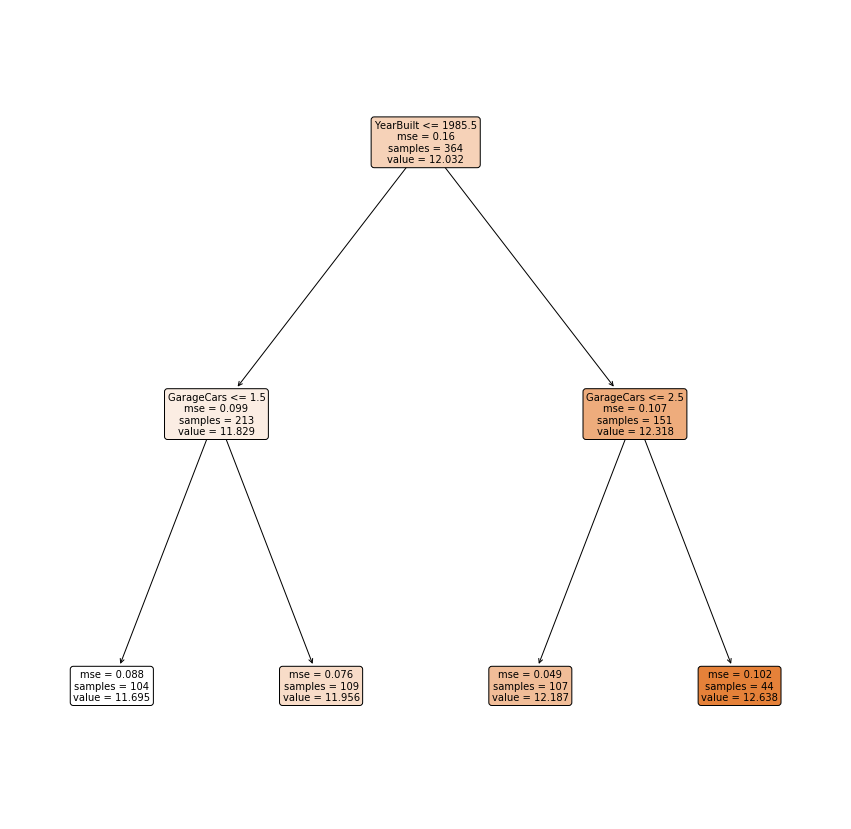

In [96]:
interaction_list = []
for i in range(1,2):
    df_rows = X.sample(frac=0.25)
    all_columns_index = list(range(0,239))
    sample_columns = sample(all_columns_index, 30)
    df_sample = df_rows.iloc[:, sample_columns]
    df_sample['SalePrice_log'] = y
    X_sample = df_sample.drop('SalePrice_log', axis = 1)
    y_sample = df_sample['SalePrice_log']
    model = tree.DecisionTreeRegressor(max_depth = 2)
    model = model.fit(X_sample, y_sample)
    interactions = get_interactions(model, feature_names = X_sample.columns, plot_tree = True)
    #print(i)
    print(interactions)
    interaction_list.append(interactions)
    
interaction_list_final = [i[0] for i in interaction_list if len(i) < 2] + [i[0] for i in interaction_list if len(i) > 1] + [i[1] for i in interaction_list if len(i) > 1]
sorted_interaction_list_final = sorted(interaction_list_final)